Implementation of Dynamic TSNE on Guassian dataset


In [ ]:
!pip install theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 68.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668112 sha256=c96af3b0ff3319cdd1fe712036ce8cf2734bb9c579a02c22053a8a9a0c7a023f
  Stored in directory: /root/.cache/pip/wheels/84/cb/19/235b5b10d89b4621f685112f8762681570a9fa14dc1ce904d9
Successfully built theano


In [ ]:
import numpy as np
import matplotlib as plt
from sklearn.cluster import KMeans
import pylab

hsv_colors = [(0.56823266219239377, 0.82777777777777772, 0.70588235294117652),
              (0.078146611341632088, 0.94509803921568625, 1.0),
              (0.33333333333333331, 0.72499999999999998, 0.62745098039215685),
              (0.99904761904761907, 0.81775700934579443, 0.83921568627450982),
              (0.75387596899224807, 0.45502645502645506, 0.74117647058823533),
              (0.028205128205128216, 0.4642857142857143, 0.5490196078431373),
              (0.8842592592592593, 0.47577092511013214, 0.8901960784313725),
              (0.0, 0.0, 0.49803921568627452),
              (0.16774193548387095, 0.82010582010582012, 0.74117647058823533),
              (0.51539855072463769, 0.88888888888888884, 0.81176470588235294)]

rgb_colors = plt.colors.hsv_to_rgb(np.array(hsv_colors).reshape(10, 1, 3))
colors = plt.colors.ListedColormap(rgb_colors.reshape(10, 3))

def plot(Y):
    km = KMeans(
        n_clusters=10, init='random',
        n_init=10, max_iter=10000, 
        tol=1e-04, random_state=0
    )
    y_km = km.fit_predict([Y[:, 0], Y[:, 1]])
    pylab.scatter(Y[:, 0], Y[:, 1], s=30,c=y_km, cmap=colors, linewidth=0)
    pylab.show()

In [ ]:
def plot1(Y, labels):
    pylab.scatter(Y[:, 0], Y[:, 1], s=30, c=labels, cmap=colors, linewidth=0)
    pylab.show()

In [ ]:
import theano.tensor as T
import theano

epsilon = 1e-16
floath = np.float32


def sqeuclidean_var(X):
    N = X.shape[0]
    ss = (X ** 2).sum(axis=1)
    return ss.reshape((N, 1)) + ss.reshape((1, N)) - 2*X.dot(X.T)


def p_Xp_given_X_var(X, sigma, metric):
    N = X.shape[0]

    if metric == 'euclidean':
        sqdistance = sqeuclidean_var(X)
    elif metric == 'precomputed':
        sqdistance = X**2
    else:
        raise Exception('Invalid metric')

    esqdistance = T.exp(-sqdistance / ((2 * (sigma**2)).reshape((N, 1))))
    esqdistance_zd = T.fill_diagonal(esqdistance, 0)

    row_sum = T.sum(esqdistance_zd, axis=1).reshape((N, 1))

    return esqdistance_zd/row_sum  # Possibly dangerous


def p_Xp_X_var(p_Xp_given_X):
    return (p_Xp_given_X + p_Xp_given_X.T) / (2 * p_Xp_given_X.shape[0])


def p_Yp_Y_var(Y):
    sqdistance = sqeuclidean_var(Y)
    one_over = T.fill_diagonal(1/(sqdistance + 1), 0)
    return one_over/one_over.sum()  # Possibly dangerous

    
def cost_var(X, Y, sigma, metric):
    p_Xp_given_X = p_Xp_given_X_var(X, sigma, metric)
    PX = p_Xp_X_var(p_Xp_given_X)
    PY = p_Yp_Y_var(Y)
    
    PXc = T.maximum(PX, epsilon)
    PYc = T.maximum(PY, epsilon)
    return T.sum(PX * T.log(PXc / PYc))  # Possibly dangerous (clipped)


def find_sigma(X_shared, sigma_shared, N, perplexity, sigma_iters,
               metric, verbose=0):
    X = T.fmatrix('X')
    sigma = T.fvector('sigma')

    target = np.log(perplexity)

    P = T.maximum(p_Xp_given_X_var(X, sigma, metric), epsilon)

    entropy = -T.sum(P*T.log(P), axis=1)

    # Setting update for binary search interval
    sigmin_shared = theano.shared(np.full(N, np.sqrt(epsilon), dtype=floath))
    sigmax_shared = theano.shared(np.full(N, np.inf, dtype=floath))

    sigmin = T.fvector('sigmin')
    sigmax = T.fvector('sigmax')

    upmin = T.switch(T.lt(entropy, target), sigma, sigmin)
    upmax = T.switch(T.gt(entropy, target), sigma, sigmax)

    givens = {X: X_shared, sigma: sigma_shared, sigmin: sigmin_shared,
              sigmax: sigmax_shared}
    updates = [(sigmin_shared, upmin), (sigmax_shared, upmax)]

    update_intervals = theano.function([], entropy, givens=givens,
                                       updates=updates)

    # Setting update for sigma according to search interval
    upsigma = T.switch(T.isinf(sigmax), sigma*2, (sigmin + sigmax)/2.)

    givens = {sigma: sigma_shared, sigmin: sigmin_shared,
              sigmax: sigmax_shared}
    updates = [(sigma_shared, upsigma)]

    update_sigma = theano.function([], sigma, givens=givens, updates=updates)

    for i in range(sigma_iters):
        e = update_intervals()
        update_sigma()
        if verbose:
            print('Iteration: {0}.'.format(i+1))
            print('Perplexities in [{0:.4f}, {1:.4f}].'.format(np.exp(e.min()),
                  np.exp(e.max())))

    if np.any(np.isnan(np.exp(e))):
        raise Exception('Invalid sigmas. The perplexity is probably too low.')

In [ ]:
def movement_penalty(Ys, N):
    penalties = []
    for t in range(len(Ys) - 1):
        penalties.append(T.sum((Ys[t] - Ys[t + 1])**2))

    return T.sum(penalties)/(2*N)


def find_Ys(Xs_shared, Ys_shared, sigmas_shared, N, steps, output_dims,
            n_epochs, initial_lr, final_lr, lr_switch, init_stdev,
            initial_momentum, final_momentum, momentum_switch, lmbda, metric,
            verbose=0):
    """Optimize cost wrt Ys[t], simultaneously for all t"""
    # Optimization hyperparameters
    initial_lr = np.array(initial_lr, dtype=floath)
    final_lr = np.array(final_lr, dtype=floath)
    initial_momentum = np.array(initial_momentum, dtype=floath)
    final_momentum = np.array(final_momentum, dtype=floath)

    lr = T.fscalar('lr')
    lr_shared = theano.shared(initial_lr)

    momentum = T.fscalar('momentum')
    momentum_shared = theano.shared(initial_momentum)

    # Penalty hyperparameter
    lmbda_var = T.fscalar('lmbda')
    lmbda_shared = theano.shared(np.array(lmbda, dtype=floath))

    # Yv velocities
    Yvs_shared = []
    zero_velocities = np.zeros((N, output_dims), dtype=floath)
    for t in range(steps):
        Yvs_shared.append(theano.shared(np.array(zero_velocities)))

    # Cost
    Xvars = T.fmatrices(steps)
    Yvars = T.fmatrices(steps)
    Yv_vars = T.fmatrices(steps)
    sigmas_vars = T.fvectors(steps)

    c_vars = []
    for t in range(steps):
        c_vars.append(cost_var(Xvars[t], Yvars[t], sigmas_vars[t], metric))

    cost = T.sum(c_vars) + lmbda_var*movement_penalty(Yvars, N)

    # Setting update for Ys velocities
    grad_Y = T.grad(cost, Yvars)

    givens = {lr: lr_shared, momentum: momentum_shared,
              lmbda_var: lmbda_shared}
    updates = []
    for t in range(steps):
        updates.append((Yvs_shared[t], momentum*Yv_vars[t] - lr*grad_Y[t]))

        givens[Xvars[t]] = Xs_shared[t]
        givens[Yvars[t]] = Ys_shared[t]
        givens[Yv_vars[t]] = Yvs_shared[t]
        givens[sigmas_vars[t]] = sigmas_shared[t]

    update_Yvs = theano.function([], cost, givens=givens, updates=updates)

    # Setting update for Ys positions
    updates = []
    givens = dict()
    for t in range(steps):
        updates.append((Ys_shared[t], Yvars[t] + Yv_vars[t]))
        givens[Yvars[t]] = Ys_shared[t]
        givens[Yv_vars[t]] = Yvs_shared[t]

    update_Ys = theano.function([], [], givens=givens, updates=updates)

    # Momentum-based gradient descent
    for epoch in range(n_epochs):
        if epoch == lr_switch:
            lr_shared.set_value(final_lr)
        if epoch == momentum_switch:
            momentum_shared.set_value(final_momentum)

        c = update_Yvs()
        update_Ys()
        if verbose:
            print('Epoch: {0}. Cost: {1:.6f}.'.format(epoch + 1, float(c)))

    Ys = []
    for t in range(steps):
        Ys.append(np.array(Ys_shared[t].get_value(), dtype=floath))

    return Ys


def dynamic_tsne(Xs, perplexity=30, Ys=None, output_dims=2, n_epochs=50,
                 initial_lr=2400, final_lr=200, lr_switch=250, init_stdev=1e-4,
                 sigma_iters=50, initial_momentum=0.5, final_momentum=0.8,
                 momentum_switch=250, lmbda=0.0, metric='euclidean',
                 random_state=None, verbose=1):
    """Compute sequence of projections from a sequence of matrices of
    observations (or distances) using dynamic t-SNE.
    
    Parameters
    ----------
    Xs : list of array-likes, each with shape (n_observations, n_features), \
            or (n_observations, n_observations) if `metric` == 'precomputed'.
        List of matrices containing the observations (one per row). If `metric` 
        is 'precomputed', list of pairwise dissimilarity (distance) matrices. 
        Each row in `Xs[t + 1]` should correspond to the same row in `Xs[t]`, 
        for every time step t > 1.
    
    perplexity : float, optional (default = 30)
        Target perplexity for binary search for sigmas.
        
    Ys : list of array-likes, each with shape (n_observations, output_dims), \
            optional (default = None)
        List of matrices containing the starting positions for each point at
        each time step.
    
    output_dims : int, optional (default = 2)
        Target dimension.
        
    n_epochs : int, optional (default = 1000)
        Number of gradient descent iterations.
        
    initial_lr : float, optional (default = 2400)
        The initial learning rate for gradient descent.
        
    final_lr : float, optional (default = 200)
        The final learning rate for gradient descent.
        
    lr_switch : int, optional (default = 250)
        Iteration in which the learning rate changes from initial to final.
        This option effectively subsumes early exaggeration.
        
    init_stdev : float, optional (default = 1e-4)
        Standard deviation for a Gaussian distribution with zero mean from
        which the initial coordinates are sampled.
        
    sigma_iters : int, optional (default = 50)
        Number of binary search iterations for target perplexity.
        
    initial_momentum : float, optional (default = 0.5)
        The initial momentum for gradient descent.
        
    final_momentum : float, optional (default = 0.8)
        The final momentum for gradient descent.
        
    momentum_switch : int, optional (default = 250)
        Iteration in which the momentum changes from initial to final.
        
    lmbda : float, optional (default = 0.0)
        Movement penalty hyperparameter. Controls how much each point is
        penalized for moving across time steps.
        
    metric : 'euclidean' or 'precomputed', optional (default = 'euclidean')
        Indicates whether `X[t]` is composed of observations ('euclidean') 
        or distances ('precomputed'), for all t.
    
    random_state : int or np.RandomState, optional (default = None)
        Integer seed or np.RandomState object used to initialize the
        position of each point. Defaults to a random seed.
    verbose : bool (default = 1)
        Indicates whether progress information should be sent to standard 
        output.
        
    Returns
    -------
    Ys : list of array-likes, each with shape (n_observations, output_dims)
        List of matrices representing the sequence of projections. 
        Each row (point) in `Ys[t]` corresponds to a row (observation or 
        distance to other observations) in the input matrix `Xs[t]`, for all t.
    """
    random_state = check_random_state(random_state)

    steps = len(Xs)
    N = Xs[0].shape[0]

    if Ys is None:
        Y = random_state.normal(0, init_stdev, size=(N, output_dims))
        Ys = [Y]*steps

    for t in range(steps):
        if Xs[t].shape[0] != N or Ys[t].shape[0] != N:
            raise Exception('Invalid datasets.')

        Xs[t] = np.array(Xs[t], dtype=floath)

    Xs_shared, Ys_shared, sigmas_shared = [], [], []
    for t in range(steps):
        X_shared = theano.shared(Xs[t])
        sigma_shared = theano.shared(np.ones(N, dtype=floath))

        find_sigma(X_shared, sigma_shared, N, perplexity, sigma_iters,
                   metric=metric, verbose=verbose)

        Xs_shared.append(X_shared)
        Ys_shared.append(theano.shared(np.array(Ys[t], dtype=floath)))
        sigmas_shared.append(sigma_shared)

    Ys = find_Ys(Xs_shared, Ys_shared, sigmas_shared, N, steps, output_dims,
                 n_epochs, initial_lr, final_lr, lr_switch, init_stdev,
                 initial_momentum, final_momentum, momentum_switch, lmbda,
                 metric, verbose)

    return Ys

Iteration: 1.
Perplexities in [491.9264, 1165.7199].
Iteration: 2.
Perplexities in [1.0188, 64.4233].
Iteration: 3.
Perplexities in [10.0628, 473.4300].
Iteration: 4.
Perplexities in [4.4989, 411.5721].
Iteration: 5.
Perplexities in [18.1202, 202.4478].
Iteration: 6.
Perplexities in [37.1711, 124.3017].
Iteration: 7.
Perplexities in [50.7382, 93.4966].
Iteration: 8.
Perplexities in [60.0016, 80.9576].
Iteration: 9.
Perplexities in [64.5297, 75.3694].
Iteration: 10.
Perplexities in [67.2266, 72.5631].
Iteration: 11.
Perplexities in [68.6066, 71.3117].
Iteration: 12.
Perplexities in [69.3045, 70.6237].
Iteration: 13.
Perplexities in [69.6555, 70.3292].
Iteration: 14.
Perplexities in [69.8247, 70.1607].
Iteration: 15.
Perplexities in [69.9149, 70.0781].
Iteration: 16.
Perplexities in [69.9558, 70.0405].
Iteration: 17.
Perplexities in [69.9782, 70.0198].
Iteration: 18.
Perplexities in [69.9893, 70.0095].
Iteration: 19.
Perplexities in [69.9946, 70.0048].
Iteration: 20.
Perplexities in [69.

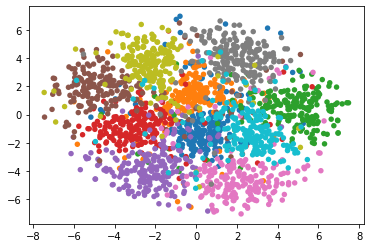

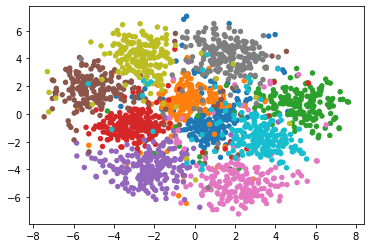

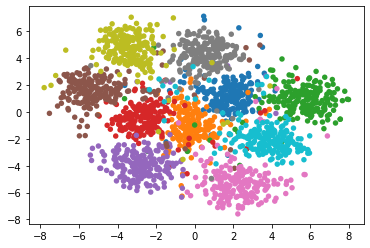

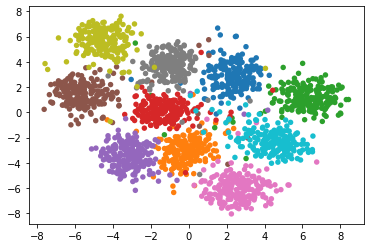

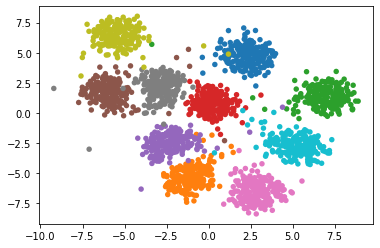

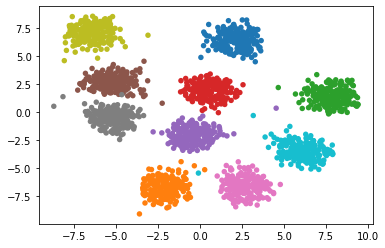

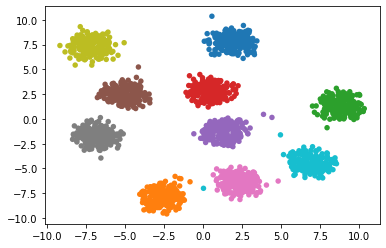

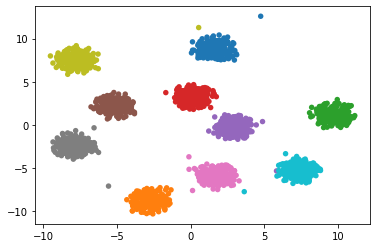

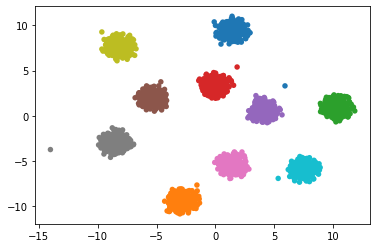

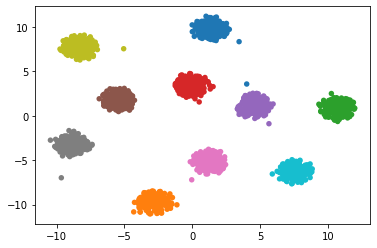

In [ ]:
from sklearn.utils import check_random_state
def create_blobs(classes=10, dims=100, class_size=100, variance=0.1, steps=4,
                 advection_ratio=0.5, random_state=None):
    random_state = check_random_state(random_state)
    X = []

    indices = random_state.permutation(dims)[0:classes]
    means = []
    for c in range(classes):
        mean = np.zeros(dims)
        mean[indices[c]] = 1.0
        means.append(mean)

        X.append(random_state.multivariate_normal(mean, np.eye(dims)*variance,
                                                  class_size))
    X = np.concatenate(X)
    y = np.concatenate([[i]*class_size for i in range(classes)])

    Xs = [np.array(X)]
    for step in range(steps - 1):
        Xnext = np.array(Xs[step])
        for c in range(classes):
            stard, end = class_size*c, class_size*(c + 1)
            Xnext[stard: end] += advection_ratio*(means[c] - Xnext[stard: end])

        Xs.append(Xnext)

    return Xs, y


def main():
    seed = 0

    Xs, y = create_blobs(class_size=200, advection_ratio=0.1, steps=10,
                         random_state=seed)

    Ys = dynamic_tsne(Xs, perplexity=70, lmbda=0.1, verbose=1, sigma_iters=50,
                      random_state=seed)

    for Y in Ys:
        plot1(Y,y)


if __name__ == "__main__":
    main()

In [ ]:
from sklearn.utils import check_random_state
import pandas as pd
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()
df=pd.read_parquet('AGG_GI_NE_NAME_5_MIN-DEST_NE_NAME-2022-10-04_00_00_00_2022-10-04_01_00_00.parquet')
df['min'] = df['ts'].dt.minute
r = df[['min']]
s = scaler.fit_transform(df.drop(['ts','DEST_NE_NAME','min'],axis=1))
t = pd.DataFrame(s,columns=[ 'Procedure Count', 'TCP Syn Count',
       'HTTP 1xx Count', 'HTTP 2xx Count', 'HTTP 3xx Count', 'HTTP 4xx Count',
       'HTTP 5xx Count', 'Total Video Count', 'Total Poor Video Quality Count',
       'Total Video No Play Count', 'Total Poor Video Resolution Count',
       'Average Rebuffer Event Count', 'Average HTTP Get Count',
       'Average Freeze Count', 'Total Video Resolution 1 Time (msec)',
       'Total Video Resolution 2 Time (msec)',
       'Total Video Resolution 3 Time (msec)',
       'Total Video Resolution 4 Time (msec)', 'DNS Failure Latency (msec)',
       'DNS Success Latency (msec)', 'Internet Latency (msec)',
       'RAN Latency (msec)', 'RTSP Time to Start (msec)', 'TTFB (msec)',
       'Duration (msec)', 'Round Trip Time (msec)', 'HTTP Latency (msec)',
       'Average Rebuffering Time (msec)', 'Average Video Duration (msec)',
       'Average Minimal Playback Time (msec)', 'Success Rate (%)',
       'Retransmitted Frame Ratio DL (%)', 'Retransmitted Frame Ratio UL (%)',
       'TCP Fin Ratio (%)', 'TCP Reset Ratio (%)',
       'Missing Packet Ratio DL (%)', 'Missing Packet Ratio UL (%)',
       'Out of Order Packet Ratio DL (%)', 'Out of Order Packet Ratio UL (%)',
       'HTTP Get Success Rate (%)', 'HTTP No Response Rate (%)',
       'Poor Video Quality Ratio (%)', 'Video No Play Ratio (%)',
       'Average Video with Rebuffering (%)', 'Poor Video Resolution Ratio (%)',
       'Handover Ratio (%)', 'Freeze Session Ratio (%)',
       'Throttled DL Ratio (%)', 'Throttled UL Ratio (%)',
       'Average Video VMOS', 'DL Data Volume (MB)', 'UL Data Volume (MB)',
       'Total Data Volume (MB)', 'Total Video GB', 'DL Throughput (kbps)',
       'UL Throughput (kbps)', 'Average Video DL Throughput (kbps)',
       'Average Effective DL Throughput (kbps)',
       'Average Effective UL Throughput (kbps)',
       'Average Peak DL Throughput (kbps)',
       'Average Peak UL Throughput (kbps)'])
df = pd.concat([t.reset_index(drop=True),r.reset_index(drop=True)],axis=1)       
def dataset():
    
    X = []
    X = df[df["min"]==0]
    X.drop(['min'],axis=1,inplace=True)
    X = X.sample(6000)
    X = X.to_numpy()
    #X = np.concatenate(X)

    Xs = [np.array(X)]
    for step in range(5,60,5):
        Xnext = df[df["min"]==step]
        Xnext.drop(['min'],axis=1,inplace=True)
        Xnext = Xnext.sample(6000)
        Xnext = Xnext.to_numpy()
        Xnext = np.array(Xnext)
        Xs.append(Xnext)
    return Xs


def main():
    seed = 0

    Xs = dataset()

    Ys = dynamic_tsne(Xs, perplexity=70, lmbda=0.1, verbose=1, sigma_iters=50,
                      random_state=seed)

    for Y in Ys:
        plot(Y)


if __name__ == "__main__":
    main()